# Model training


[2025-02-04 13:19:50,402] INFO - 1. Cargando datasets...
[2025-02-04 13:19:51,783] INFO - 
Información de los datasets:
[2025-02-04 13:19:51,784] INFO - Muestras de entrenamiento: 10055
[2025-02-04 13:19:51,785] INFO - Muestras de validación: 1673
[2025-02-04 13:19:51,786] INFO - Muestras de test: 1723
[2025-02-04 13:19:51,787] INFO - Número de clases: 101
[2025-02-04 13:19:51,788] INFO - 
2. Verificando la forma de los datos...
[2025-02-04 13:19:52,747] INFO - Shape de un batch de secuencias: (32, 16, 1280)
[2025-02-04 13:19:52,747] INFO - Shape de un batch de etiquetas: (32, 101)
[2025-02-04 13:19:52,749] INFO - 
3. Configurando parámetros...
[2025-02-04 13:19:52,750] INFO - 
4. Creando modelo...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 1280)]        0         
                                                                 
 lstm (LSTM) 

2025/02/04 18:01:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


[2025-02-04 18:01:23,697] WARNING - Found untraced functions such as _update_step_xla, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 5 of 9). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: C:\Users\gurei\AppData\Local\Temp\tmph8c1q_tq\model\data\model\assets
[2025-02-04 18:01:25,617] INFO - Assets written to: C:\Users\gurei\AppData\Local\Temp\tmph8c1q_tq\model\data\model\assets
[2025-02-04 18:01:25,943] WARNING - <src.actionDetection.components.models.lstm_FC.Attention object at 0x000001BC2B84FCD0> has the same name 'Attention' as a built-in Keras object. Consider renaming <class 'src.actionDetection.components.models.lstm_FC.Attention'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load functio

d:\Projects_D\013_OpenCV_Learning\OpenCV_Learning\venv_Awaait_v2\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


[2025-02-04 18:02:32,779] INFO - Gráficas guardadas en artifacts/plots/training_history.png


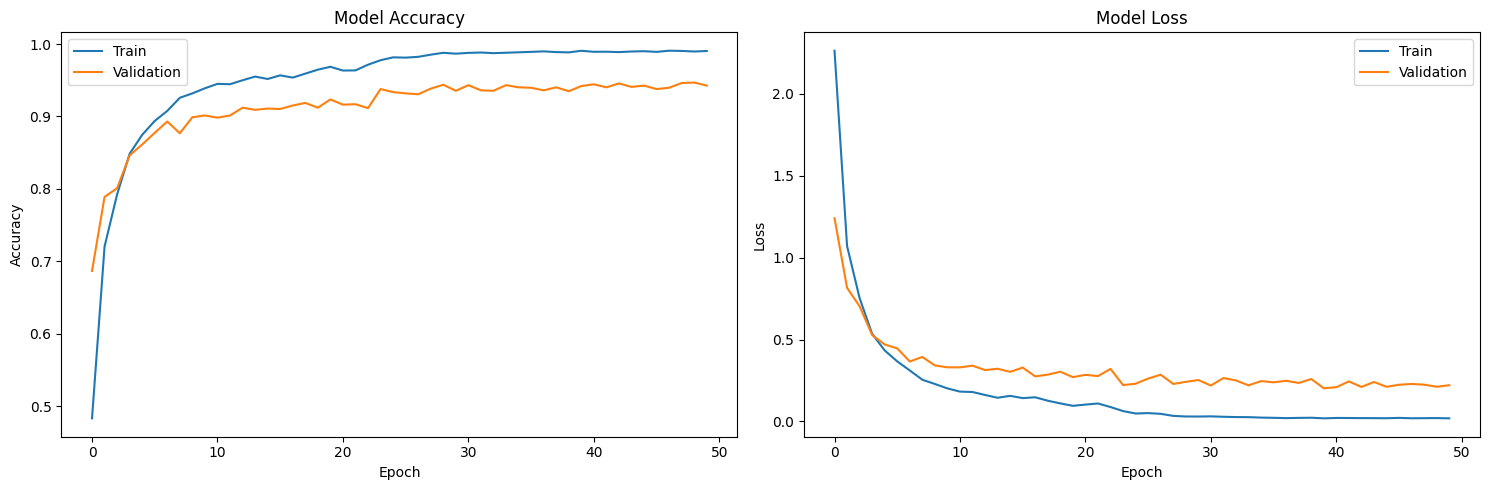

[2025-02-04 18:02:33,012] INFO - 
Métricas finales:
[2025-02-04 18:02:33,013] INFO - Test accuracy: 0.9478
[2025-02-04 18:02:33,015] INFO - Test loss: 0.1618
[2025-02-04 18:02:33,016] INFO - 
Puedes ver los resultados detallados en MLflow:
[2025-02-04 18:02:33,016] INFO - 1. Abre una terminal
[2025-02-04 18:02:33,017] INFO - 2. Navega al directorio del proyecto
[2025-02-04 18:02:33,017] INFO - 3. Ejecuta: mlflow ui
[2025-02-04 18:02:33,018] INFO - 4. Abre en tu navegador: http://localhost:5000


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Comprobando directorio proyecto
if not os.getcwd().endswith('OpenCV_Learning'):
    os.chdir('../')

from src.actionDetection.components.data.dataset import VideoDataset
from src.actionDetection.components.models.lstm_FC import create_lstm_attention_model
from src.actionDetection.components.training.trainer import ModelTrainer
from src.actionDetection.utils.logger import logger

try:
    logger.info("1. Cargando datasets...")

    # 1) Preparar datasets
    train_dataset = VideoDataset(
        root_dir="artifacts/data/processed/train",
        batch_size=32,
        sequence_length=16,
        stride=8,
        shuffle=True
    )

    val_dataset = VideoDataset(
        root_dir="artifacts/data/processed/val",
        batch_size=32,
        sequence_length=16,
        stride=8,
        shuffle=False
    )

    test_dataset = VideoDataset(
        root_dir="artifacts/data/processed/test",
        batch_size=32,
        sequence_length=16,
        stride=8,
        shuffle=False
    )

    logger.info("\nInformación de los datasets:")
    logger.info(f"Muestras de entrenamiento: {len(train_dataset.samples)}")
    logger.info(f"Muestras de validación: {len(val_dataset.samples)}")
    logger.info(f"Muestras de test: {len(test_dataset.samples)}")
    logger.info(f"Número de clases: {len(train_dataset.classes)}")

    logger.info("\n2. Verificando la forma de los datos...")
    batch_x, batch_y = next(iter(train_dataset))
    logger.info(f"Shape de un batch de secuencias: {batch_x.shape}")  
    logger.info(f"Shape de un batch de etiquetas: {batch_y.shape}")  

    # 2) Configurar parámetros
    logger.info("\n3. Configurando parámetros...")
    model_params = {
        "sequence_length": 16,
        "num_features": 1280,
        "num_classes": len(train_dataset.classes),
        "lstm_units": [256, 128],
        "dropout_rate": 0.3
    }

    training_params = {
        "experiment_name": "LSTM_Attention_Classification",
        "epochs": 50,
        "patience": 7,
        "checkpoint_dir": "artifacts/models",
        "max_checkpoints": 3
    }

    # 3) Crear el modelo
    logger.info("\n4. Creando modelo...")
    model = create_lstm_attention_model(**model_params)
    model.summary()

    # 4) Instanciar el trainer
    trainer = ModelTrainer(model_params, training_params)

    # 5) Entrenar
    logger.info("\n5. Iniciando entrenamiento...")
    logger.info("Nota: Puedes interrumpir el entrenamiento con Ctrl+C")
    history, test_loss, test_acc = trainer.train(
        model,
        train_dataset,
        val_dataset,
        test_dataset
    )

    # 6) Visualizar resultados si el entrenamiento completa
    if history is not None:
        # Crear directorio para gráficas si no existe
        os.makedirs('artifacts/plots', exist_ok=True)
        
        plt.figure(figsize=(15, 5))

        # -- ACCURACY --
        plt.subplot(1, 2, 1)
        # Usa 'categorical_accuracy' si tu modelo está compilado con esa métrica
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # -- LOSS --
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        
        # Guardar la gráfica
        plt.savefig('artifacts/plots/training_history.png')
        logger.info("Gráficas guardadas en artifacts/plots/training_history.png")

        # Mostrar la gráfica
        plt.show()

        # Log final
        logger.info("\nMétricas finales:")
        logger.info(f"Test accuracy: {test_acc:.4f}")
        logger.info(f"Test loss: {test_loss:.4f}")

except KeyboardInterrupt:
    logger.info("\nEntrenamiento interrumpido por el usuario")
except Exception as e:
    logger.error(f"\nError en la ejecución: {str(e)}")
    logger.error(f"Detalles del error: {str(e.__class__.__name__)}")
    raise

In [3]:
x_batch, y_batch = train_dataset[0]
print("Shape X_batch:", x_batch.shape)
print("Shape y_batch:", y_batch.shape)
print("Labels in batch:", np.argmax(y_batch, axis=1))

Shape X_batch: (32, 16, 1280)
Shape y_batch: (32, 101)
Labels in batch: [27 49 56 57 58 44 86  0 84 34 70 72 64 74 23 33 13 32 56 93 68 33  5 94
 97 53 35 58  3 51 95 61]


In [5]:
train_dataset

# Model testing


In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import load_model
from src.actionDetection.components.data.dataset import VideoDataset
from src.actionDetection.components.models.lstm_FC import Attention
from src.actionDetection.utils.logger import logger

try:
    # 1. Cargar el dataset de test
    logger.info("Cargando dataset de test...")
    test_dataset = VideoDataset(
        root_dir="artifacts/data/processed/test",
        batch_size=32,
        sequence_length=16,
        stride=8,
        shuffle=False
    )

    # 2. Cargar el modelo guardado
    logger.info("Cargando modelo...")
    model_path = "artifacts/models/checkpoint_epoch_40.h5"
    model = load_model(model_path, custom_objects={'Attention': Attention})
    
    # 3. Realizar predicciones
    logger.info("Realizando predicciones...")
    all_predictions = []
    all_true_labels = []
    all_files = []  # Para guardar los nombres de los archivos
    
    for i in range(len(test_dataset)):
        x_batch, y_batch = test_dataset[i]
        predictions = model.predict(x_batch, verbose=0)
        
        # Guardar predicciones y etiquetas reales
        pred_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        
        all_predictions.extend(pred_labels)
        all_true_labels.extend(true_labels)
        
        # Obtener los nombres de archivo para este batch
        batch_files = [test_dataset.samples[j]['path'].name for j in range(i*test_dataset.batch_size, 
                      min((i+1)*test_dataset.batch_size, len(test_dataset.samples)))]
        all_files.extend(batch_files)
    
    # 4. Crear DataFrame con los resultados
    results_df = pd.DataFrame({
        'Archivo': all_files,
        'Clase Real': [test_dataset.classes[label] for label in all_true_labels],
        'Predicción': [test_dataset.classes[pred] for pred in all_predictions],
        'Correcto': [pred == true for pred, true in zip(all_predictions, all_true_labels)]
    })
    
    # 5. Mostrar resumen de resultados
    logger.info("\nResumen de predicciones:")
    print("\nPrimeras 10 predicciones:")
    print(results_df.head(10))
    
    print("\nResumen de accuracy por clase:")
    accuracy_by_class = results_df.groupby('Clase Real')['Correcto'].agg(['count', 'mean'])
    accuracy_by_class.columns = ['Total Muestras', 'Accuracy']
    accuracy_by_class = accuracy_by_class.sort_values('Accuracy', ascending=False)
    print(accuracy_by_class)
    
    # 6. Guardar resultados en CSV
    csv_path = 'artifacts/results/test_predictions.csv'
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    results_df.to_csv(csv_path, index=False)
    logger.info(f"\nResultados guardados en: {csv_path}")

except Exception as e:
    logger.error(f"\nError en la evaluación: {str(e)}")
    raise

[2025-02-04 20:04:09,407] INFO - Cargando dataset de test...
[2025-02-04 20:04:09,490] INFO - Cargando modelo...
[2025-02-04 20:04:11,483] INFO - Realizando predicciones...
[2025-02-04 20:05:04,671] INFO - 
Resumen de predicciones:

Primeras 10 predicciones:
                                 Archivo      Clase Real      Predicción  \
0  v_ApplyEyeMakeup_g01_c02_features.npy  ApplyEyeMakeup  ApplyEyeMakeup   
1  v_ApplyEyeMakeup_g01_c04_features.npy  ApplyEyeMakeup  ApplyEyeMakeup   
2  v_ApplyEyeMakeup_g02_c01_features.npy  ApplyEyeMakeup  ApplyEyeMakeup   
3  v_ApplyEyeMakeup_g02_c04_features.npy  ApplyEyeMakeup         Haircut   
4  v_ApplyEyeMakeup_g04_c07_features.npy  ApplyEyeMakeup  ApplyEyeMakeup   
5  v_ApplyEyeMakeup_g05_c03_features.npy  ApplyEyeMakeup  ApplyEyeMakeup   
6  v_ApplyEyeMakeup_g05_c05_features.npy  ApplyEyeMakeup  ApplyEyeMakeup   
7  v_ApplyEyeMakeup_g06_c02_features.npy  ApplyEyeMakeup  ApplyEyeMakeup   
8  v_ApplyEyeMakeup_g09_c01_features.npy  ApplyEyeMakeup 

In [7]:
results_df.head()

,Archivo,Clase Real,Predicción,Correcto
0,v_ApplyEyeMakeup_g01_c02_features.npy,ApplyEyeMakeup,ApplyEyeMakeup,True
1,v_ApplyEyeMakeup_g01_c04_features.npy,ApplyEyeMakeup,ApplyEyeMakeup,True
2,v_ApplyEyeMakeup_g02_c01_features.npy,ApplyEyeMakeup,ApplyEyeMakeup,True
3,v_ApplyEyeMakeup_g02_c04_features.npy,ApplyEyeMakeup,Haircut,False
4,v_ApplyEyeMakeup_g04_c07_features.npy,ApplyEyeMakeup,ApplyEyeMakeup,True


In [10]:
accuracy_by_class[accuracy_by_class["Accuracy"]>0.98].shape

(58, 2)

In [ ]:
# Calcular los cuantiles cada 10%
quantiles = np.arange(0, 1.1, 0.1)
accuracy_quantiles = accuracy_by_class['Accuracy'].quantile(quantiles)

# Crear un DataFrame con los resultados
quantile_df = pd.DataFrame({
    'Percentil': [f'{int(q*100)}%' for q in quantiles],
    'Accuracy': accuracy_quantiles.values
})

print("Accuracy por cuantiles:")
print(quantile_df)

print("\nDataFrame original ordenado por accuracy:")
accuracy_by_class

Accuracy por cuantiles:
   Percentil  Accuracy
0         0%  0.176471
1        10%  0.857143
2        20%  0.923077
3        30%  0.941176
4        40%  0.950000
5        50%  1.000000
6        60%  1.000000
7        70%  1.000000
8        80%  1.000000
9        90%  1.000000
10      100%  1.000000

DataFrame original ordenado por accuracy:


,Total Muestras,Accuracy
Clase Real,,
SkyDiving,14,1.000000
SoccerJuggling,19,1.000000
Skiing,17,1.000000
HandstandPushups,16,1.000000
HandstandWalking,14,1.000000
...,...,...
WalkingWithDog,16,0.812500
FieldHockeyPenalty,16,0.750000
JavelinThrow,15,0.666667


In [13]:
accuracy_by_class["Total Muestras"].sum()

1723

[2025-02-04 20:34:22,567] INFO - 
Análisis de la clase BasketballDunk:

Casos donde BasketballDunk fue la clase real:
Predicción
Basketball        14
BasketballDunk     3
dtype: int64

Casos donde el modelo predijo BasketballDunk:
Clase Real
Basketball        16
BasketballDunk     3
dtype: int64


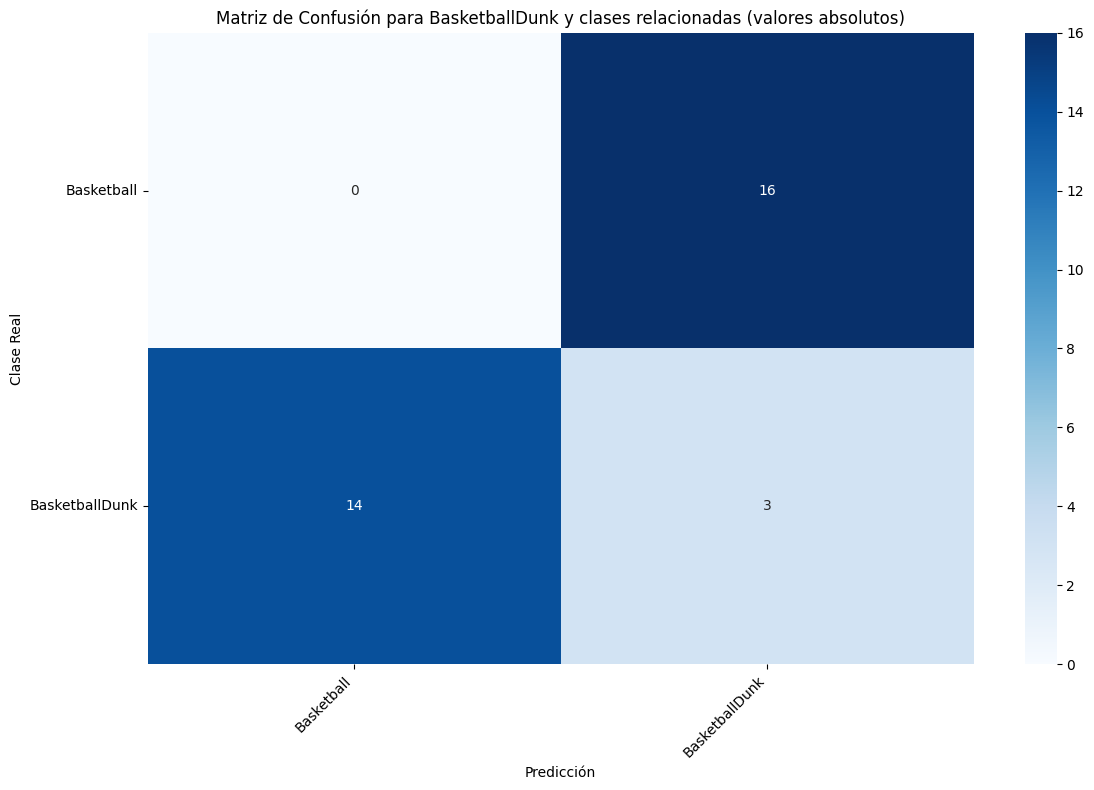

[2025-02-04 20:34:23,009] INFO - 
Métricas para BasketballDunk:
[2025-02-04 20:34:23,011] INFO - Total de muestras: 17
[2025-02-04 20:34:23,013] INFO - Predicciones correctas: 3
[2025-02-04 20:34:23,015] INFO - Accuracy: 17.65%

Ejemplos de clasificaciones erróneas de BasketballDunk:
                                   Archivo      Clase Real  Predicción
157  v_BasketballDunk_g01_c02_features.npy  BasketballDunk  Basketball
158  v_BasketballDunk_g01_c04_features.npy  BasketballDunk  Basketball
159  v_BasketballDunk_g01_c05_features.npy  BasketballDunk  Basketball
160  v_BasketballDunk_g02_c01_features.npy  BasketballDunk  Basketball
161  v_BasketballDunk_g02_c02_features.npy  BasketballDunk  Basketball
162  v_BasketballDunk_g05_c01_features.npy  BasketballDunk  Basketball
164  v_BasketballDunk_g11_c04_features.npy  BasketballDunk  Basketball
165  v_BasketballDunk_g13_c03_features.npy  BasketballDunk  Basketball
166  v_BasketballDunk_g15_c07_features.npy  BasketballDunk  Basketball
167  

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.actionDetection.utils.logger import logger

try:
    # 1. Matriz de confusión para BasketballDunk
    logger.info("\nAnálisis de la clase BasketballDunk:")
    
    # Filtrar predicciones relacionadas con BasketballDunk
    basketball_df = results_df[
        (results_df['Clase Real'] == 'BasketballDunk') | 
        (results_df['Predicción'] == 'BasketballDunk')
    ]
    
    print("\nCasos donde BasketballDunk fue la clase real:")
    print(basketball_df[basketball_df['Clase Real'] == 'BasketballDunk']
          .groupby('Predicción')
          .size()
          .sort_values(ascending=False))
    
    print("\nCasos donde el modelo predijo BasketballDunk:")
    print(basketball_df[basketball_df['Predicción'] == 'BasketballDunk']
          .groupby('Clase Real')
          .size()
          .sort_values(ascending=False))
    
    # 2. Crear matriz de confusión específica
    plt.figure(figsize=(12, 8))
    
    # Obtener clases únicas involucradas
    classes = sorted(list(set(
        basketball_df['Clase Real'].unique().tolist() + 
        basketball_df['Predicción'].unique().tolist()
    )))
    
    # Crear matriz de confusión sin normalizar
    conf_matrix = pd.crosstab(
        basketball_df['Clase Real'], 
        basketball_df['Predicción']
    )
    
    # Visualizar con seaborn
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',  # 'd' para mostrar números enteros
        cmap='Blues',
        xticklabels=True,
        yticklabels=True
    )
    
    plt.title('Matriz de Confusión para BasketballDunk y clases relacionadas (valores absolutos)')
    plt.xlabel('Predicción')
    plt.ylabel('Clase Real')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Ajustar layout y guardar
    plt.tight_layout()
    plt.savefig('artifacts/plots/basketball_dunk_confusion_absolute.png')
    plt.show()
    
    # 3. Métricas específicas para BasketballDunk
    total_bd = len(results_df[results_df['Clase Real'] == 'BasketballDunk'])
    correct_bd = len(results_df[
        (results_df['Clase Real'] == 'BasketballDunk') & 
        (results_df['Predicción'] == 'BasketballDunk')
    ])
    
    logger.info("\nMétricas para BasketballDunk:")
    logger.info(f"Total de muestras: {total_bd}")
    logger.info(f"Predicciones correctas: {correct_bd}")
    logger.info(f"Accuracy: {correct_bd/total_bd:.2%}")
    
    # 4. Ver ejemplos específicos de errores
    print("\nEjemplos de clasificaciones erróneas de BasketballDunk:")
    errors_df = results_df[
        (results_df['Clase Real'] == 'BasketballDunk') & 
        (results_df['Predicción'] != 'BasketballDunk')
    ]
    print(errors_df[['Archivo', 'Clase Real', 'Predicción']])

except Exception as e:
    logger.error(f"\nError en el análisis: {str(e)}")
    raise